column Popularity has 2.55% missing values
column danceability has 0.0% missing values
column energy has 0.0% missing values
column key has 10.98% missing values
column loudness has 0.0% missing values
column mode has 0.0% missing values
column speechiness has 0.0% missing values
column acousticness has 0.0% missing values
column instrumentalness has 24.45% missing values
column liveness has 0.0% missing values
column valence has 0.0% missing values
column tempo has 0.0% missing values
column duration_in min/ms has 0.0% missing values
column time_signature has 0.0% missing values
column Class has 30.0% missing values


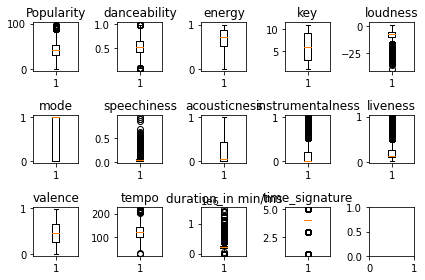

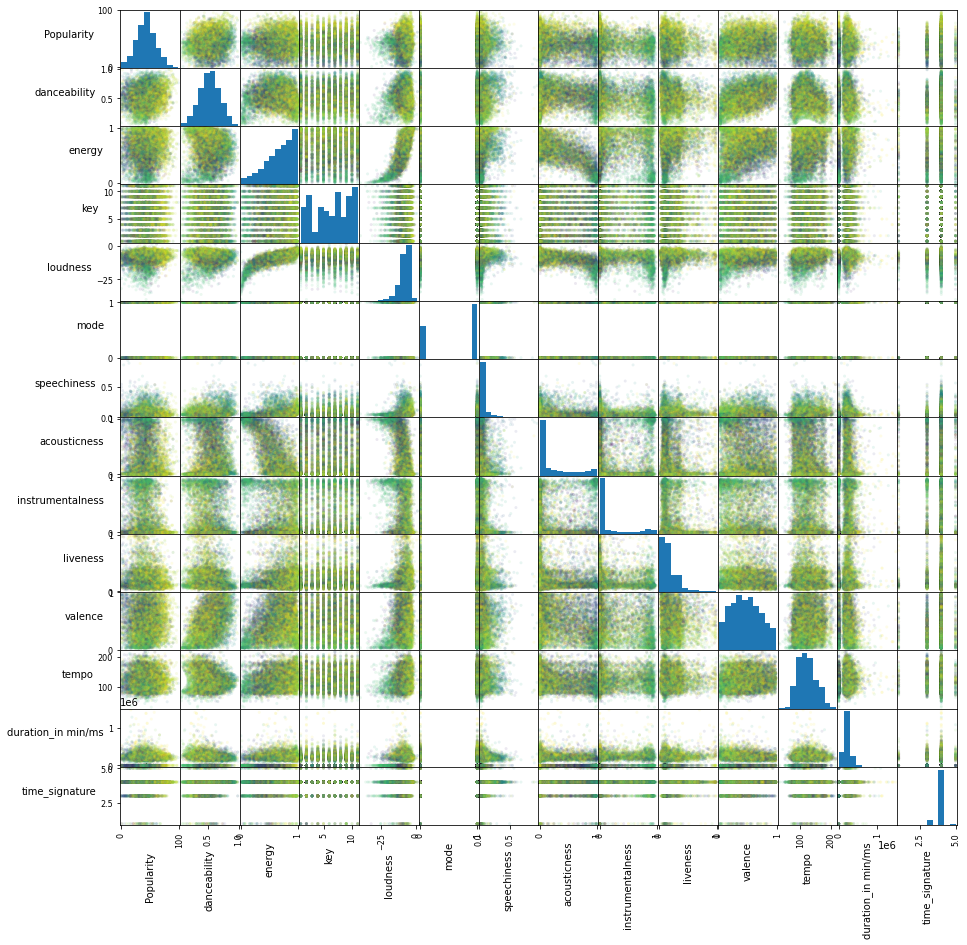

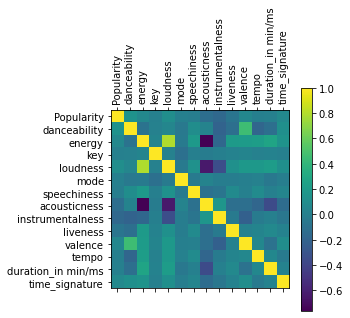

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter 

#loading the dataset

df1 = pd.read_csv('/Users/melikeerbek/Desktop/archive/train.csv').drop(columns=['Artist Name', 'Track Name'])
df2 = pd.read_csv('/Users/melikeerbek/Desktop/archive/test.csv').drop(columns=['Artist Name', 'Track Name'])

df = pd.concat([df1,df2])


keys = df.keys()
numcols = len(keys)
df

#check for missing values
for k in keys:
    print(f'column {k} has {np.round(df[k].isna().sum()/len(df)*100, 2)}% missing values')
    
#Populatirity has 2.55% missing values -> can be filled
#key, instrumentalness and the Target have very high missing value rates -> mvs should be removed as to not alter the 
#distribution

df = df[df['instrumentalness'].notna()]
df = df[df['key'].notna()]
df = df[df['Class'].notna()]

target = df['Class']
numTargets = len(set(target))
df.drop(columns=['Class'], inplace = True)
keys = df.keys()
numcols = len(keys)

target

#Fill Popularity mv with median, because all popularities seem to be integer
df.fillna(np.mean(df['Popularity']), inplace = True)
df

#Univariate Analysis
means = {}
medians = {}
stdevs = {}
for k in keys:
    mean = np.mean(df[df[k].notna()][k])
    med = np.median(df[df[k].notna()][k])
    std = np.sqrt(np.mean((df[k]-mean)**2))
    means[k] = mean
    medians[k] = med
    stdevs[k] = std

means,medians,stdevs


#Visualise each distribution using a boxplot
n = 3
m = 5
fig, axs = plt.subplots(n,m)


for i in range(n):
    for j in range(m):
        idx = i*m+j 
        if (idx < numcols):
            axs[i][j].boxplot(df[keys[idx]])
            axs[i][j].title.set_text(keys[idx])
            
plt.tight_layout()


#Bivariate Analysis
#Visualize each pair of variables

axes = pd.plotting.scatter_matrix(df, alpha = 0.1, figsize = (15,15), c  =target);
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    
    
#Normalisation
#No strong non linear dependence can be seen in above plots.
#as such a simple min max scaler to the [0,1] intervall is used
maxs = np.max(df, axis = 0)
mins = np.min(df, axis = 0)


for k in keys:
    df[k] = (df[k]-mins[k])/(maxs[k]-mins[k])

#repeat means and stdev calculation
means = {}
medians = {}
stdevs = {}
for k in keys:
    mean = np.mean(df[df[k].notna()][k])
    med = np.median(df[df[k].notna()][k])
    std = np.sqrt(np.mean((df[k]-mean)**2))
    means[k] = mean
    medians[k] = med
    stdevs[k] = std

    
df


#Calculate and visualize Correlation between each pair of variables

correlations = df.corr()

plt.matshow(correlations)
plt.colorbar()
plt.xticks(range(numcols), keys, rotation = 90);
plt.yticks(range(numcols), keys, rotation = 0);
correlations


#Only one highly correlated variable pair obvious, which is "energy" and "loudness", a correlation that could have
#been expected.
#Witch a correlation of .795 this variable can be removed while barely losing any information.

df.drop(columns=['loudness'], inplace = True)
keys = df.keys()
df


#Map Each cluster label to what true label it most labels
def mapPredAndTrue(tar, pred):
    convMat = np.array(confusion_matrix(tar, pred, normalize = 'true'))
    
    
    translation = np.argmax(convMat, axis = 0)

    predLabel = pred.copy()

    return translation[predLabel]


from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score

from tqdm import tqdm

uppLimFak = 3
silhouetteScores = []
homogeneityScores = []

clusterings = []
possMetrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
nClustersToCheck = range(numTargets, uppLimFak*numTargets)

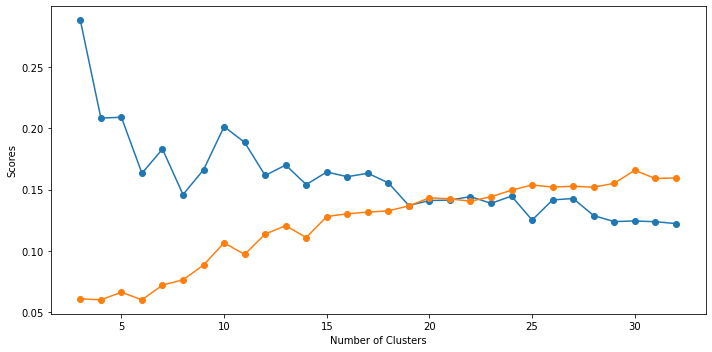

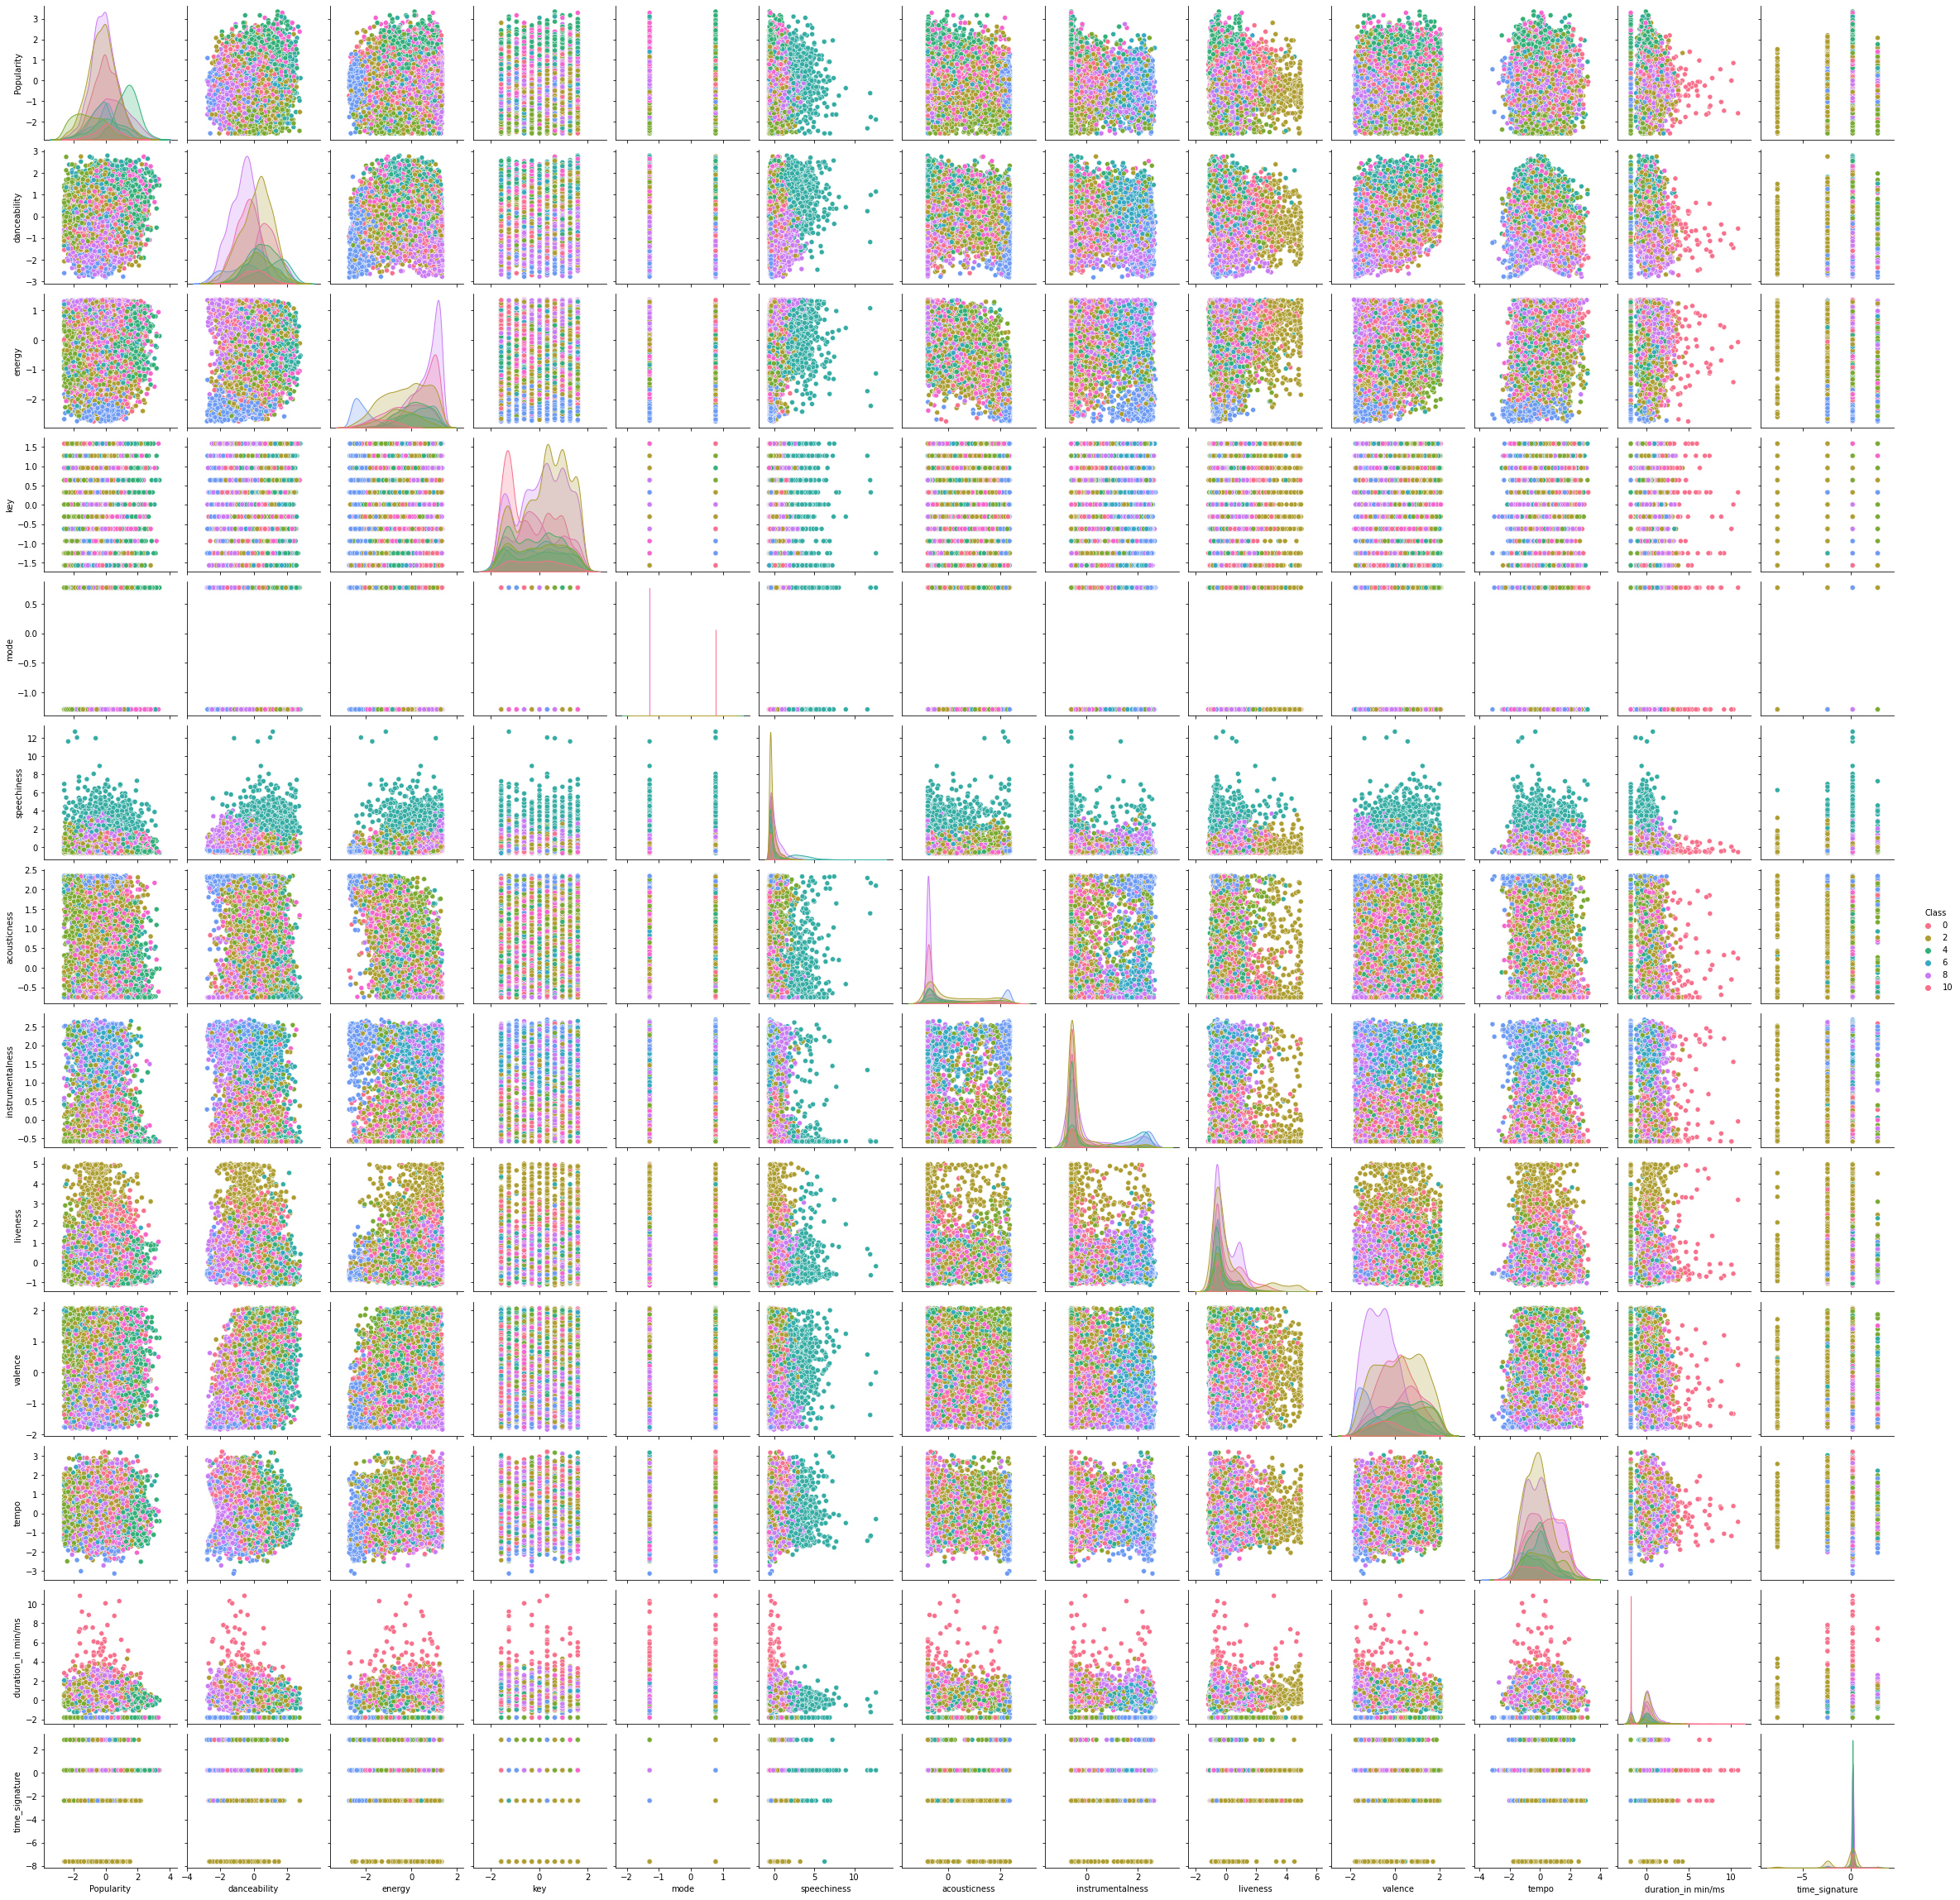

GM Homogeneity Score: 0.1657249427373388
GM Silhouette Score: 0.12435850523861292


In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns 


scaler = StandardScaler()                    # standardization
df_standardized = scaler.fit_transform(df)   


n_clust_range = range(3, uppLimFak * numTargets)  # range of clusters


silhouette_scores = []
homogeneity_scores = []


for n_clust in n_clust_range:       # grid search over number of clusters
    
    gmm = GaussianMixture(n_components=n_clust, covariance_type='spherical')     # Gaussian mixture fit
    gmm.fit(df)
    
    
    clust_labels = gmm.predict(df)     # predicting cluster labels
    
    
    silhouette_all = silhouette_score(df, clust_labels)             # silhouette and homogeneity scores
    homogeneity_all = homogeneity_score(target, clust_labels)
    
    
    silhouette_scores.append(silhouette_all)
    homogeneity_scores.append(homogeneity_all)


plt.figure(figsize=(10, 5))        # scores plot


plt.plot(n_clust_range, silhouette_scores, label='Silhouette Score', marker='o')
plt.plot(n_clust_range, homogeneity_scores, label='Homogeneity Score', marker='o')

plt.xlabel('Number of Clusters')
plt.ylabel('Scores')

plt.tight_layout()
plt.show()

best_n_clust = n_clust_range[np.argmax(homogeneity_scores)]    # best number of clusters depending on homogeneity score


gmm = GaussianMixture(n_components=best_n_clust, covariance_type='spherical')     # Gaussian fit with best number of clusters
gmm_labels = gmm.fit_predict(df_standardized)


gmm_labels_true = mapPredAndTrue(target, gmm_labels)    # mapping predicted labels to true labels


df_gmm = pd.DataFrame(data=df_standardized, columns=keys)     # adding labels to dataframe
df_gmm['Class'] = gmm_labels_true  


sns.pairplot(df_gmm, hue="Class", palette="husl")        # cluster visualization
plt.show()


print(f"GM Homogeneity Score: {max(homogeneity_scores)}")        # homogeneity and silhouette scores
print(f"GM Silhouette Score: {silhouette_scores[best_n_clust-3]}")